# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
from jax import vmap
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List
import time

from scripts.texture_descriptor import compute_texture_descriptor, rgb2gray, rgb2lab
from scripts.filters import gaussian_kernel_2d
from scripts.despeckling import unnormalized_bilateral_filter, dual_unnormalized_bilateral_filter, compute_similarity_map, extract_patches_2d

print(jax.devices())

[CpuDevice(id=0)]


In [ ]:
def extract_patches(
        tensor: jnp.ndarray, 
        kernel_size: int,
        start_index: Tuple[int, int],
        end_indices: Tuple[int, int]) -> jnp.ndarray:
    """
    Extracts sliding patches from a 2D or 3D tensor.

    Parameters:
    tensor: (H, W, D) or (H, W)
    kernel_size: int (odd)
    Returns: (H, W, kernel_size, kernel_size, D) or (H, W, kernel_size, kernel_size)
    """
    H, W = tensor.shape[:2]
    D = tensor.shape[2:]

    pad = kernel_size // 2
    tensor = jnp.pad(tensor, ((pad, pad), (pad, pad)) + ((0, 0),) * len(D), mode='reflect')
    h_idx = jnp.arange(H)
    w_idx = jnp.arange(W)

    def get_patch(i, j):
        patch = jax.lax.dynamic_slice(operand=tensor, 
                                      start_indices=(i, j) + (0,)*len(D), 
                                      slice_sizes=(kernel_size, kernel_size) + D)
        return patch

    patches = jax.vmap(
        lambda i: jax.vmap(lambda j: get_patch(i, j))(w_idx)
    )(h_idx)
    return patches 

In [2]:
opt = Image.open('/home/nus/Downloads/optical_sar_data/optical.png')
sar = Image.open('/home/nus/Downloads/optical_sar_data/sar.png')

opt_rgb = jnp.array(opt) / 255.0
sar = jnp.array(sar) / 255.0
sar = jnp.expand_dims(sar, axis=-1)  # (H, W, 1)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape)

(256, 256, 1) (256, 256, 1) (256, 256, 3)


In [3]:
radius = 21

time_start = time.time()
S = compute_texture_descriptor(opt_lab, radius)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

2.0119 seconds


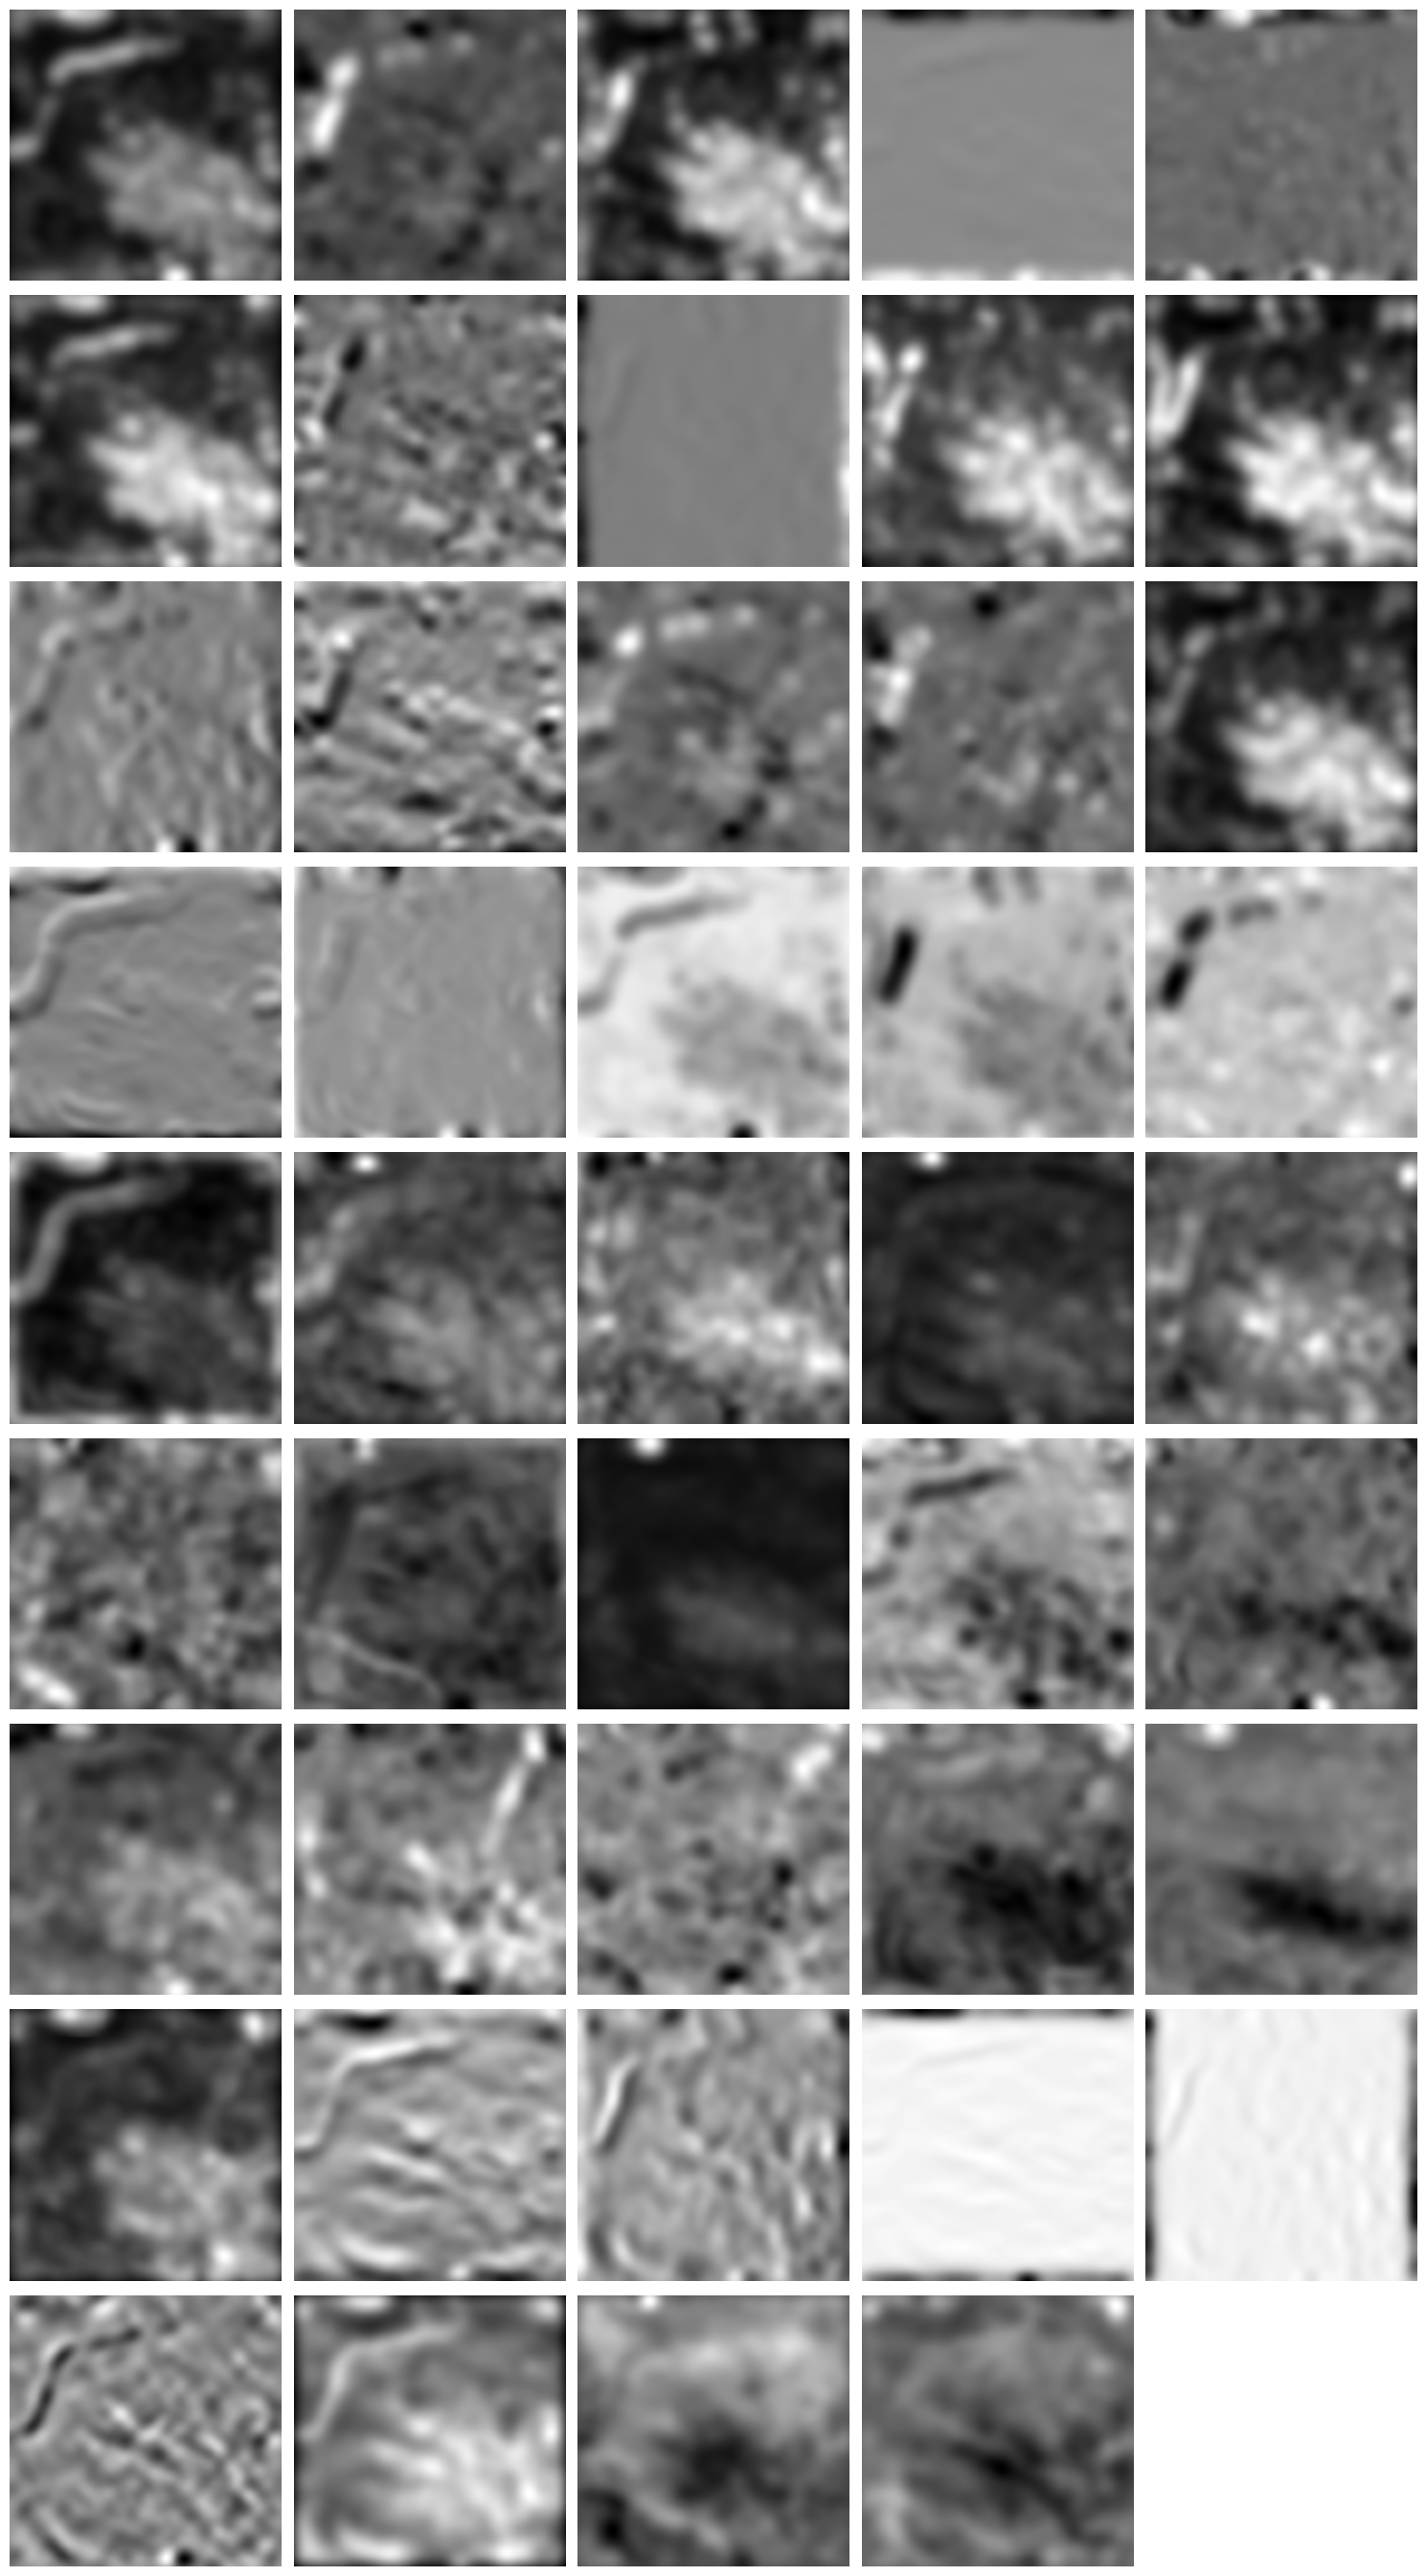

In [4]:
D = S.shape[-1]

N = 5  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### UBF

In [5]:
L = opt_gray

time_start = time.time()
S_ubf, error = unnormalized_bilateral_filter(S, L, sigma_s=5, sigma_l=0.05, alpha_ubf=2, n_iter=30)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

UBF Iterations: 100%|██████████| 30/30 [02:38<00:00,  5.27s/it]


159.2456 seconds


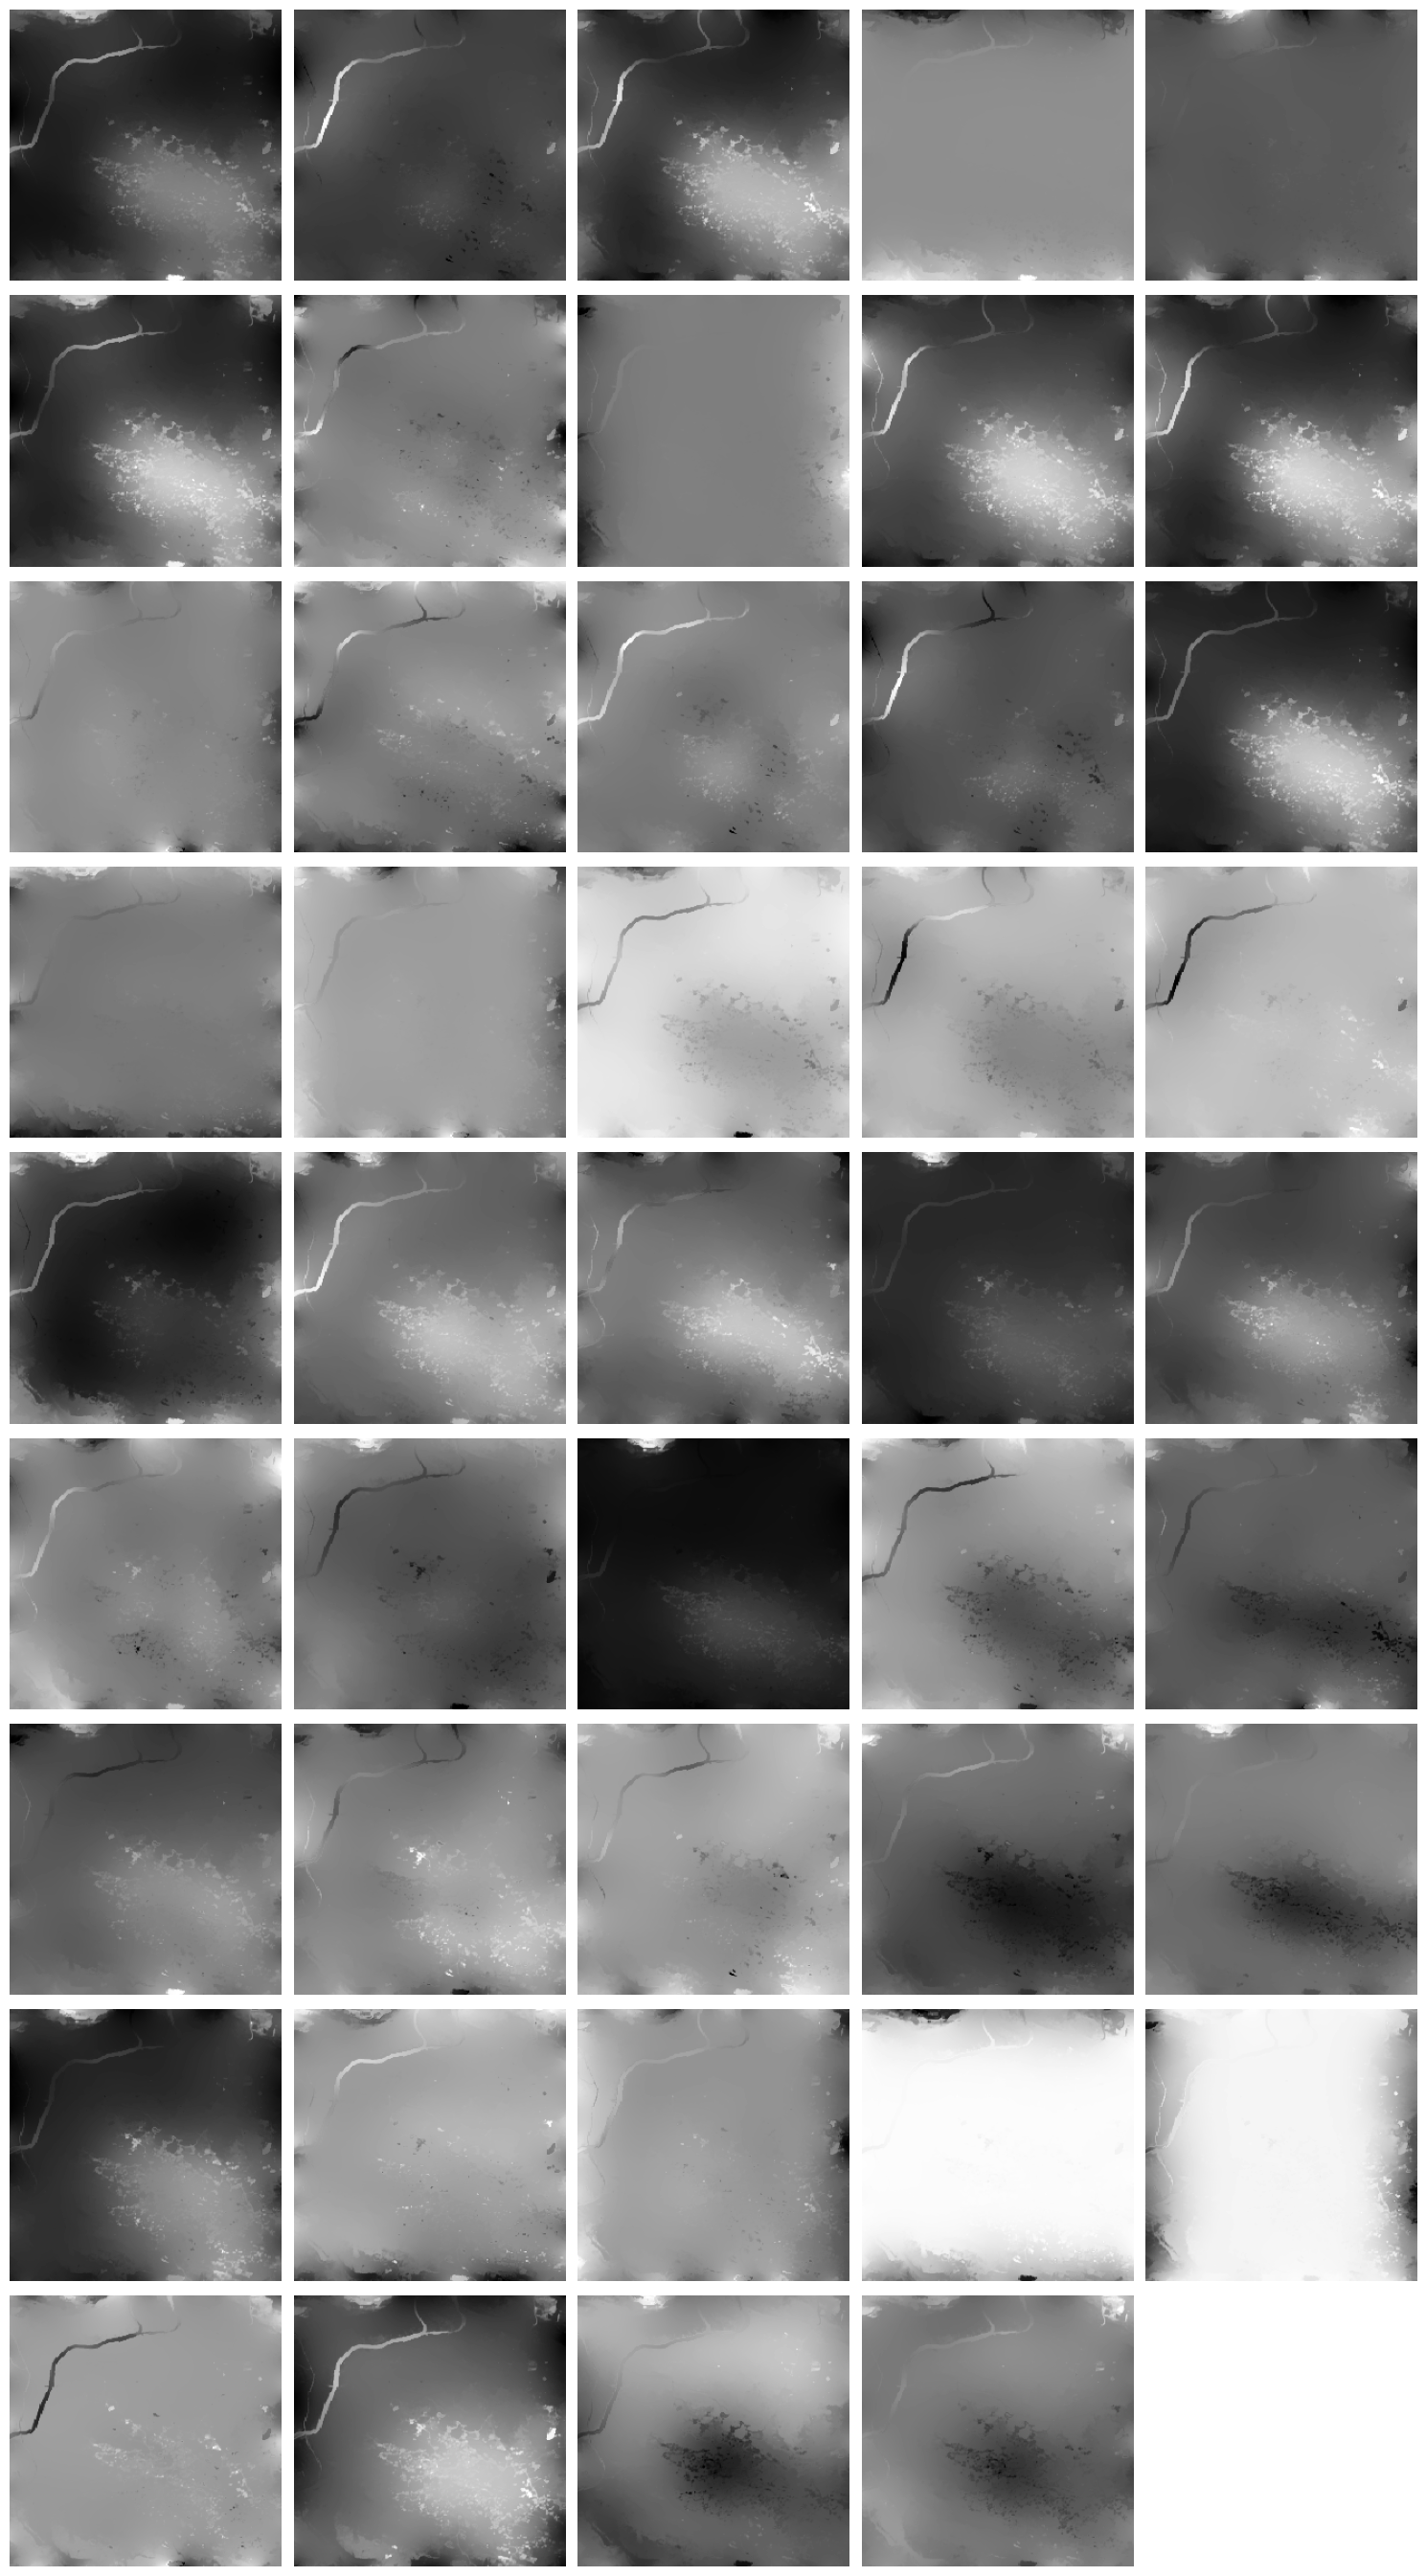

In [6]:
D = S_ubf.shape[-1]

N = 5  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_ubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

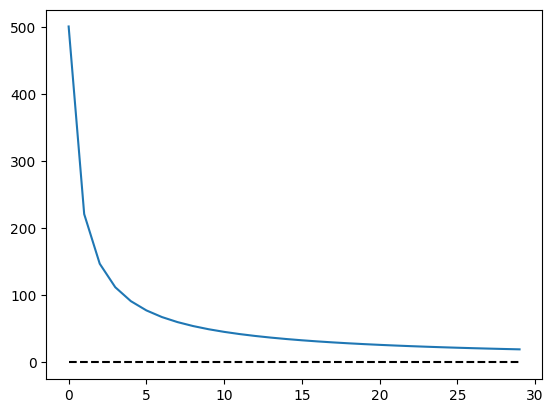

In [7]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### DUBF

In [8]:
L_opt = opt_gray
L_sar = sar  # (H, W, 1)

time_start = time.time()
S_dubf, error = dual_unnormalized_bilateral_filter(S, L_opt, L_sar, sigma_s=5, sigma_l_opt=0.1, sigma_l_sar=0.1, alpha_ubf=2, n_iter=30)
time_end = time.time()
print(f"{time_end - time_start:.4f} seconds")

DUBF Iterations: 100%|██████████| 30/30 [02:45<00:00,  5.51s/it]


166.1846 seconds


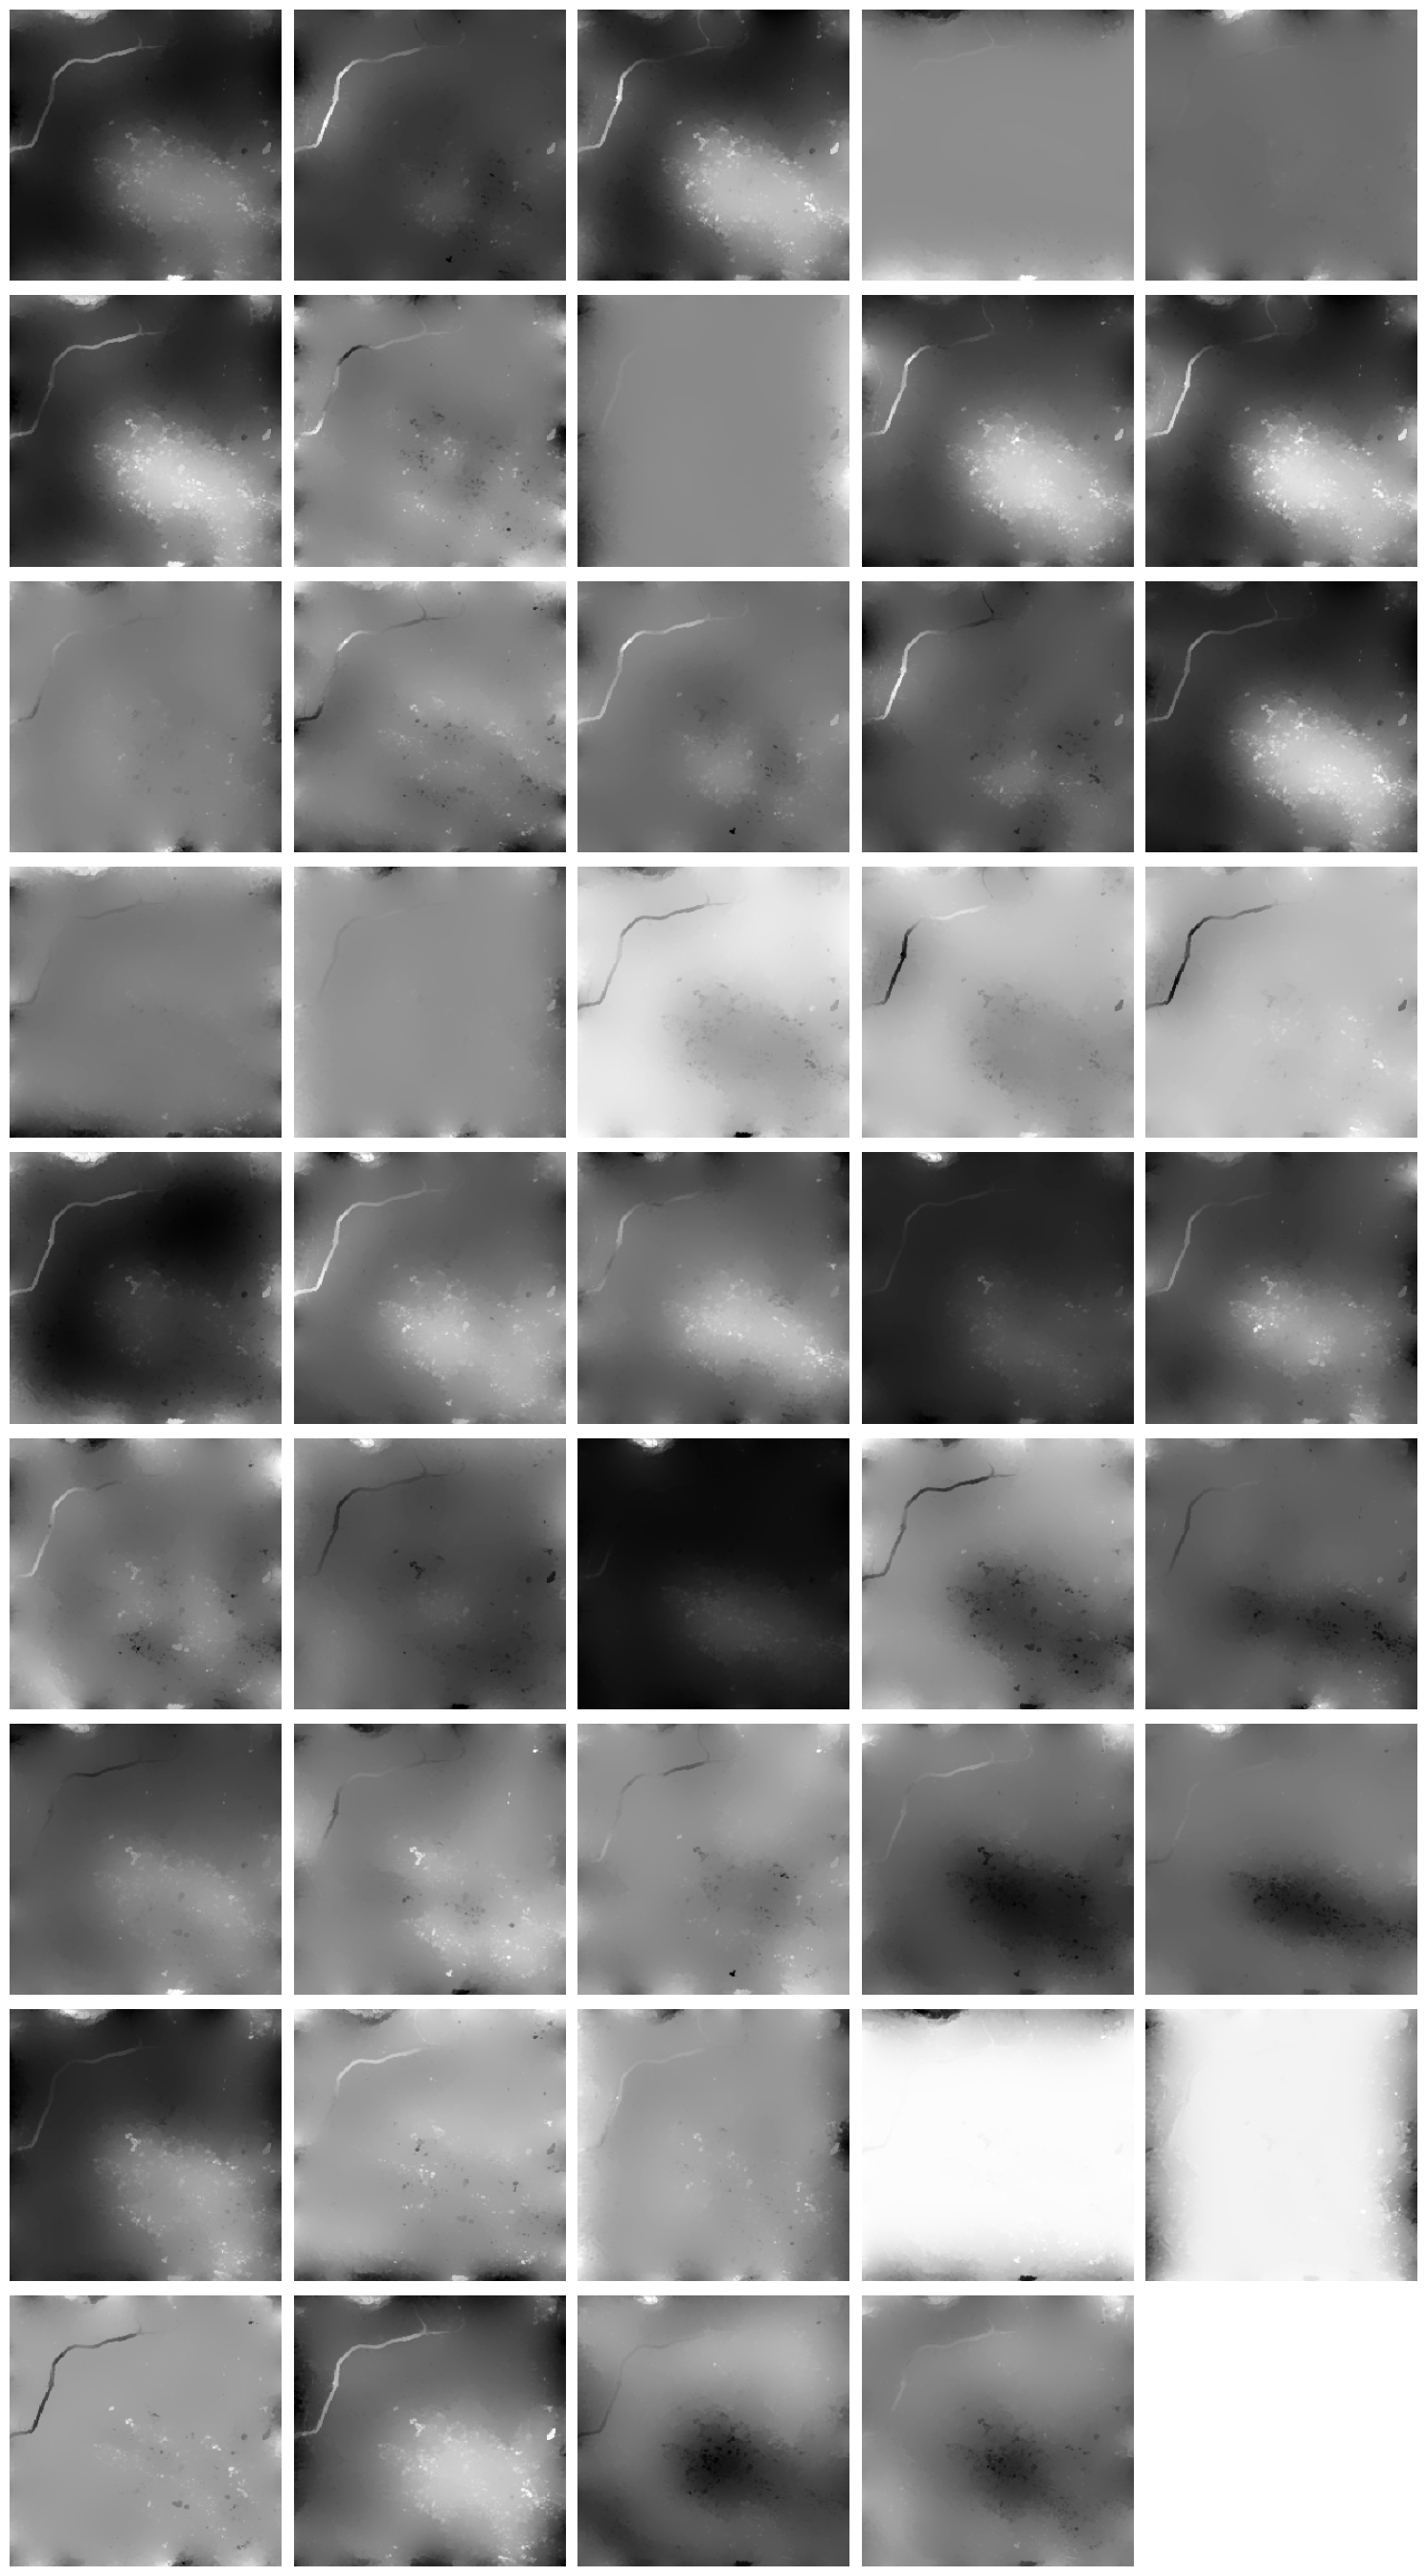

In [9]:
D = S_dubf.shape[-1]

N = 5  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_dubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

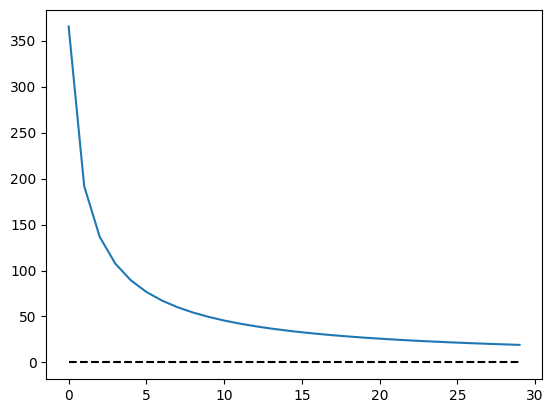

In [10]:
plt.plot(error)
plt.plot(np.arange(len(error)), np.zeros_like(error), 'k--')

### Despeckle

In [11]:
def despeckle(sar: jnp.ndarray, descriptor: jnp.ndarray, 
             sigma_d: float = 4) -> jnp.ndarray:
    """
    Despeckle SAR image using dual unnormalized bilateral filter.

    Parameters
    ----------
    sar : jnp.ndarray
        SAR image (H, W, C)
    descriptor : jnp.ndarray
        Texture descriptor (H, W, D)
    sigma_s : float
        Spatial standard deviation for the Gaussian kernel.
    sigma_l_opt : float
        Luminance standard deviation for optical image.
    sigma_l_sar : float
        Luminance standard deviation for SAR image.
    alpha_ubf : float
        Scaling factor for the update step.
    n_iter : int
        Number of iterations.

    Returns
    -------
    jnp.ndarray
        Despeckled SAR image (H, W, C)
    """
    return NotImplementedError

(256, 256)


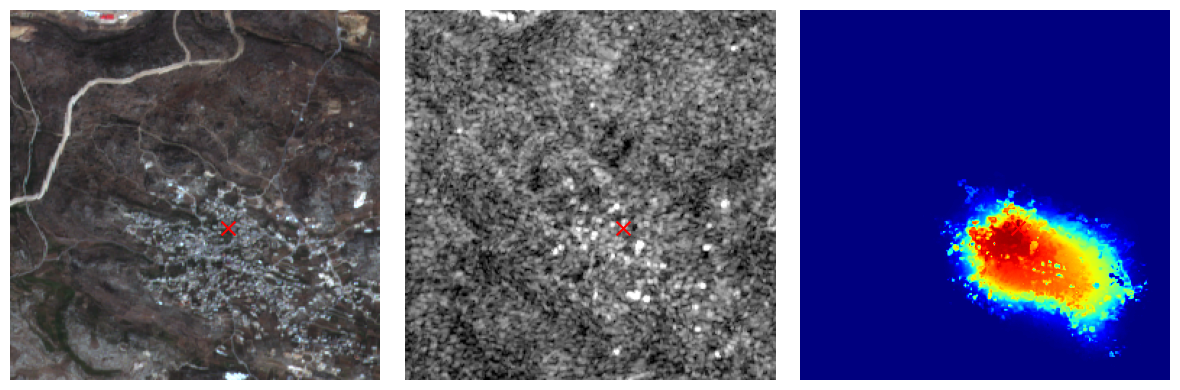

In [12]:
i, j = 150, 150  # width, height -> x, y
sigma_d = 3

similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
print(similarity_map.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(opt)
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(similarity_map, cmap='jet')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.tight_layout()

(256, 256)


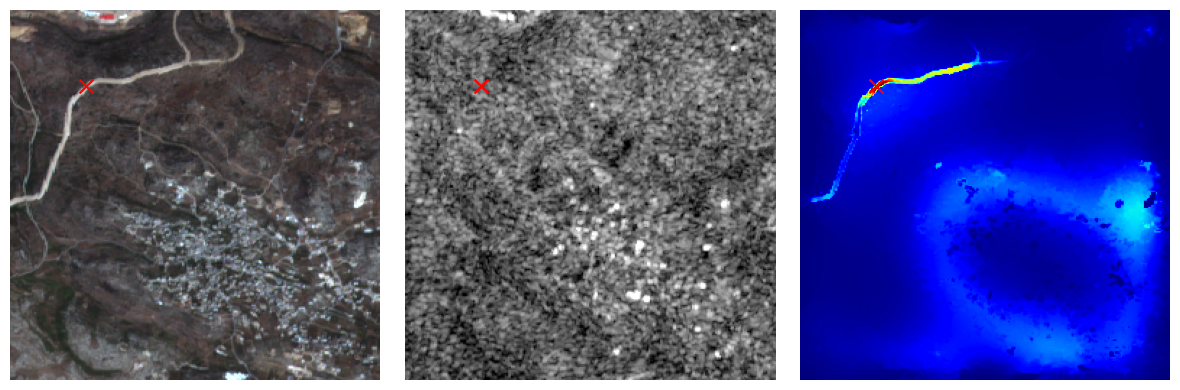

In [13]:
i, j = 52, 52  # width, height -> x, y
sigma_d = 5

similarity_map = compute_similarity_map(S_dubf[j, i, :], S_dubf, sigma_d=sigma_d)  # y, x
print(similarity_map.shape)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(opt)
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(similarity_map, cmap='jet')
plt.scatter(i, j, c='r', s=100, marker='x')  # x, y
plt.axis('off')
plt.tight_layout()

In [37]:
def despeckle(S: jnp.ndarray, sar: jnp.ndarray, sigma_d: float = 0.005, window_size: int = 15, tau: float = 0.9) -> jnp.ndarray:
    H, W = S.shape[0], S.shape[1]
    sar_filtered = sar.copy() 
    speed_up = jnp.zeros((H, W), dtype=bool)  # Speed-up mask
    values = sar.squeeze()

    progress_bar = tqdm(total=H*W, desc='Filtering')
    for j in range(H):
        for i in range(W):
            if not speed_up[j, i]:
                S_p = S[j, i, :]

                # Compute similarity map (distance in feature space)
                similarity_map = compute_similarity_map(S_p, S, sigma_d=sigma_d)

                # Compute filtered value
                numerator = (values * similarity_map).sum()
                mu_p = numerator / (similarity_map.sum())
                
                # Apply filtered value
                speed_up_indices = jnp.where(similarity_map > tau)

                for idx in range(len(speed_up_indices[0])):
                    j_idx, i_idx = speed_up_indices[0][idx], speed_up_indices[1][idx]
                    sar_filtered = sar_filtered.at[j_idx, i_idx].set(mu_p)
                    speed_up = speed_up.at[j_idx, i_idx].set(True)
                # sar_filtered = sar_filtered.at[j, i].set(mu_p)

                progress_bar.update(len(speed_up_indices[0]))
    progress_bar.close()
    return sar_filtered

In [38]:
sigma_d = 0.5
window_size = 50
tau = 0.1

# time_start = time.time()
sar_filtered = despeckle(S_dubf, sar, sigma_d=sigma_d, window_size=window_size, tau=tau)
# time_end = time.time()
# print(f"{time_end - time_start:.4f} seconds")

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.imshow(opt)
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(sar, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(sar - sar_filtered, cmap='jet')
plt.axis('off')
plt.tight_layout()

In [ ]:
def extract_local_patches(arr, window_size):
    """ Extracts (window_size x window_size) patches for each (H, W) position. 
        arr: (H, W, D) or (H, W)
        Returns: (H, W, window_size, window_size, D) or (H, W, window_size, window_size)
    """
    pad = window_size // 2
    if arr.ndim == 3:
        H, W, D = arr.shape
        arr_padded = jnp.pad(arr, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
        def get_patch(i, j):
            return arr_padded[i:i+window_size, j:j+window_size, :]
    elif arr.ndim == 2:
        H, W = arr.shape
        arr_padded = jnp.pad(arr, ((pad, pad), (pad, pad)), mode='reflect')
        def get_patch(i, j):
            return arr_padded[i:i+window_size, j:j+window_size]
    else:
        raise ValueError("arr must be 2D or 3D")
    return jax.vmap(lambda i: jax.vmap(lambda j: get_patch(i, j))(jnp.arange(W)))(jnp.arange(H))


def despeckle_windowed(
    S: jnp.ndarray,    # (H, W, D)
    sar: jnp.ndarray,  # (H, W)
    sigma_d: float = 0.005,
    window_size: int = 15,
    tau: float = 0.9
) -> jnp.ndarray:
    """
    Memory-optimized, windowed despeckle filter using JAX.
    """
    H, W, D = S.shape
    sar = sar.squeeze()
    S_patches = extract_local_patches(S, window_size)      # (H, W, window, window, D)
    sar_patches = extract_local_patches(sar, window_size)  # (H, W, window, window)

    # Get pixel's own descriptor at each location
    S_center = S  # (H, W, D)

    def filter_pixel(S_p, S_patch, sar_patch):
        # S_p: (D,), S_patch: (window, window, D), sar_patch: (window, window)
        diff = S_patch - S_p  # broadcasts (window, window, D)
        distsq = jnp.sum(diff**2, axis=-1)  # (window, window)
        similarity = jnp.exp(-distsq / (2 * sigma_d ** 2))  # (window, window)
        mask = similarity > tau
        masked_similarity = similarity * mask
        denominator = masked_similarity.sum()
        numerator = (sar_patch * masked_similarity).sum()
        mu_p = jnp.where(denominator > 0, numerator / denominator, sar_patch[window_size // 2, window_size // 2])
        return mu_p

    despeckled = jax.vmap(
        jax.vmap(filter_pixel, in_axes=(0, 0, 0)), in_axes=(0, 0, 0)
    )(S_center, S_patches, sar_patches)  # (H, W)

    return despeckled

In [ ]:
def despeckle(S: jnp.ndarray, sar: jnp.ndarray, sigma_d: float = 0.005, window_size: int = 15, tau: float = 0.9) -> jnp.ndarray:
    H, W = S.shape[0], S.shape[1]
    sar_filtered = sar.copy() 
    speed_up = jnp.zeros((H, W), dtype=bool)  # Speed-up mask

    progress_bar = tqdm(total=H*W, desc='Filtering', unit='pixel')
    for j in range(H):
        for i in range(W):
            if not speed_up[j, i]:
                S_p = S[j, i, :]  # Extract the descriptor for the current pixel

                # Extract local window
                imin, imax = max(0, i - window_size // 2), min(W, i + window_size // 2 + 1)
                jmin, jmax = max(0, j - window_size // 2), min(H, j + window_size // 2 + 1)
                S_patch = S[jmin:jmax, imin:imax, :]
                sar_patch = sar[jmin:jmax, imin:imax, :]

                # Compute similarity map (distance in feature space)
                similarity_map = compute_similarity_map(S_p, S_patch, sigma_d=sigma_d)[..., None]  # Add channel dimension

                # Compute filtered value
                numerator = (sar_patch * similarity_map).sum()
                mu_p = numerator / (similarity_map.sum())
                
                # Apply filtered value
                speed_up_indices = jnp.where(similarity_map > tau)

                for idx in range(len(speed_up_indices[0])):
                    j_idx, i_idx = speed_up_indices[0][idx], speed_up_indices[1][idx]
                    sar_filtered = sar_filtered.at[j_idx, i_idx].set(mu_p)
                    speed_up = speed_up.at[j_idx, i_idx].set(True)
                # sar_filtered = sar_filtered.at[j, i].set(mu_p)

            progress_bar.update(1)
    progress_bar.close()
    return sar_filtered